Method found: baseline
Execution Time for baseline: 15.5747
Method found: ikj
Execution Time for ikj: 5.3356
Method found: pthread_only
Execution Time for pthread_only: 0.8655
Method found: openmp_only
Execution Time for openmp_only: 1.1417
Method found: simd_only
Execution Time for simd_only: 1.6519
Method found: pthread_simd
Execution Time for pthread_simd: 0.3479
Method found: openmp_simd
Execution Time for openmp_simd: 0.2596


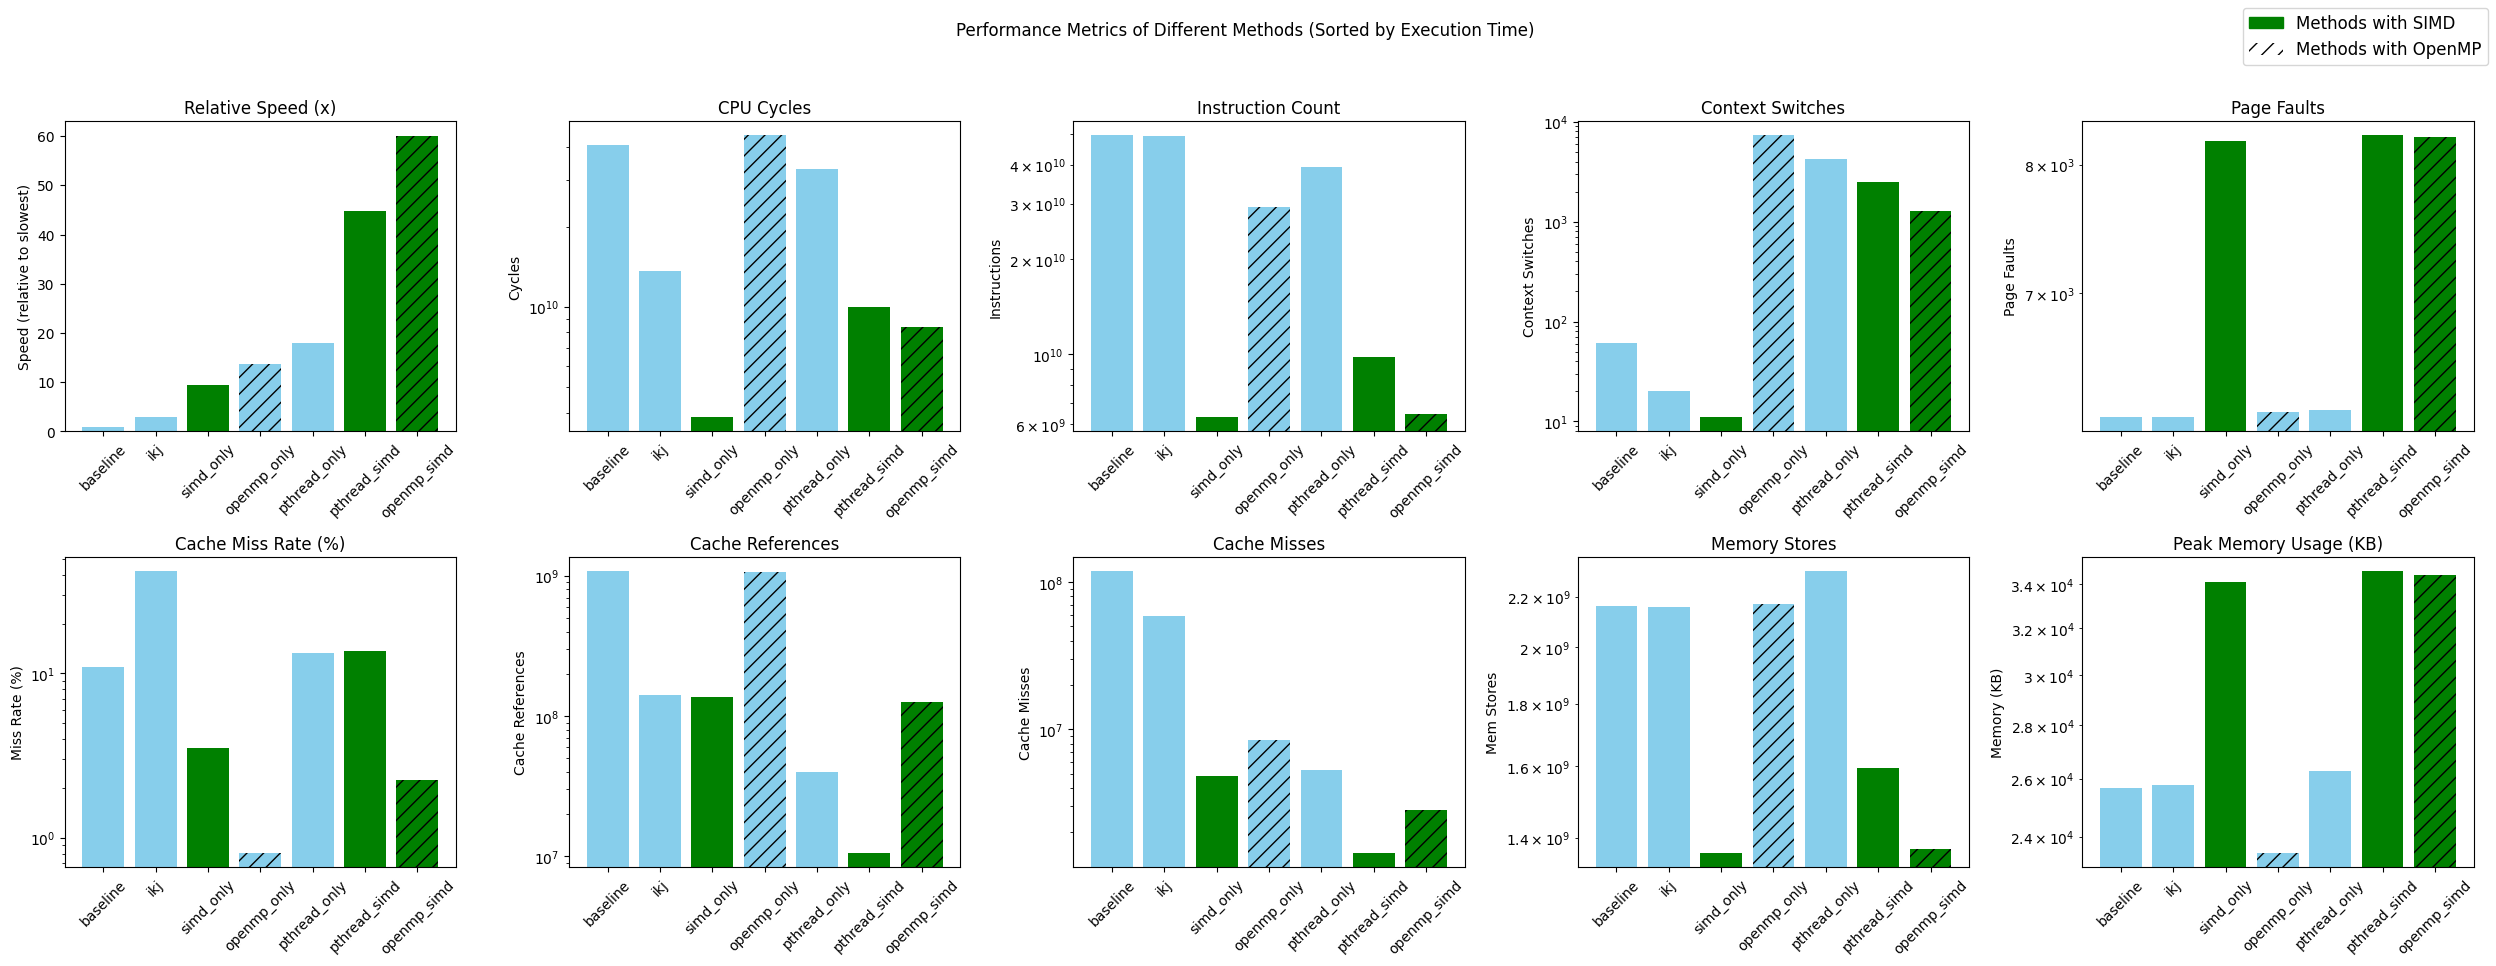

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# 定义正则表达式，用于解析 txt 文件
pattern_time = re.compile(r'Execution Time:\s+(\d+\.\d+) s')
pattern_cycles = re.compile(r'([\d,]+)\s+cycles')
pattern_instructions = re.compile(r'([\d,]+)\s+instructions')
pattern_cache_misses = re.compile(r'([\d,]+)\s+cache-misses')
pattern_cache_refs = re.compile(r'([\d,]+)\s+cache-references')
pattern_context_switches = re.compile(r'([\d,]+)\s+context-switches')
pattern_page_faults = re.compile(r'Minor Page Faults:\s+(\d+)')
pattern_mem_stores = re.compile(r'([\d,]+)\s+mem-stores')
pattern_peak_memory = re.compile(r'Current Peak Memory:\s+(\d+)\s+KB')

# 存储方法名称和对应数据
methods = []
times = []
cycles = []
instructions = []
cache_misses = []
cache_refs = []
context_switches = []
page_faults = []
mem_stores = []
peak_memory = []

# 读取并解析文件
with open('perf_results.txt', 'r') as file:
    lines = file.readlines()
    method = ""
    for line in lines:
        if "Running" in line:
            method = line.split("...")[0].split()[-1]
            methods.append(method)
            print(f"Method found: {method}")
        elif match := pattern_time.search(line):
            time = float(match.group(1))
            times.append(time)
            print(f"Execution Time for {method}: {time}")
        elif match := pattern_cycles.search(line):
            cycles.append(int(match.group(1).replace(',', '')))
        elif match := pattern_instructions.search(line):
            instructions.append(int(match.group(1).replace(',', '')))
        elif match := pattern_cache_misses.search(line):
            cache_misses.append(int(match.group(1).replace(',', '')))
        elif match := pattern_cache_refs.search(line):
            cache_refs.append(int(match.group(1).replace(',', '')))
        elif match := pattern_context_switches.search(line):
            context_switches.append(int(match.group(1).replace(',', '')))
        elif match := pattern_page_faults.search(line):
            page_faults.append(int(match.group(1).replace(',', '')))
        elif match := pattern_mem_stores.search(line):
            mem_stores.append(int(match.group(1).replace(',', '')))
        elif match := pattern_peak_memory.search(line):
            peak_memory.append(int(match.group(1)))

# 检查所有数据列表长度是否一致
data_lists = [times, cycles, instructions, cache_misses, cache_refs, context_switches, page_faults, mem_stores, peak_memory]
if not all(len(lst) == len(methods) for lst in data_lists):
    print("Error: Inconsistent data length detected.")
    print(f"Methods: {len(methods)}, Times: {len(times)}, Cache Misses: {len(cache_misses)}, and others.")

# 计算缓存缺失率
cache_miss_rate = [misses / refs * 100 if refs > 0 else 0 for misses, refs in zip(cache_misses, cache_refs)]

# 将数据按执行时间排序
sorted_indices = np.argsort(times)[::-1]  # 从大到小排序
methods = [methods[i] for i in sorted_indices]
times = [times[i] for i in sorted_indices]
cycles = [cycles[i] for i in sorted_indices]
instructions = [instructions[i] for i in sorted_indices]
cache_miss_rate = [cache_miss_rate[i] for i in sorted_indices]
context_switches = [context_switches[i] for i in sorted_indices]
page_faults = [page_faults[i] for i in sorted_indices]
mem_stores = [mem_stores[i] for i in sorted_indices]
cache_refs = [cache_refs[i] for i in sorted_indices]
cache_misses = [cache_misses[i] for i in sorted_indices]
peak_memory = [peak_memory[i] for i in sorted_indices]

# 转换 Execution Time 为相对速度
min_time = max(times)  # 最慢的执行时间作为基准
relative_speed = [min_time / t for t in times]

# 创建图形
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Performance Metrics of Different Methods (Sorted by Execution Time)')
# 绘制各项指标的柱状图
metrics = [
    (relative_speed, 'Relative Speed (x)', 'Speed (relative to slowest)'),
    (cycles, 'CPU Cycles', 'Cycles'),
    (instructions, 'Instruction Count', 'Instructions'),
    (context_switches, 'Context Switches', 'Context Switches'),
    (page_faults, 'Page Faults', 'Page Faults'),
    (cache_miss_rate, 'Cache Miss Rate (%)', 'Miss Rate (%)'),
    (cache_refs, 'Cache References', 'Cache References'),
    (cache_misses, 'Cache Misses', 'Cache Misses'),
    (mem_stores, 'Memory Stores', 'Mem Stores'),
    (peak_memory, 'Peak Memory Usage (KB)', 'Memory (KB)')
]

# 绘制每个指标的子图
for ax, (data, title, ylabel) in zip(axs.flat, metrics):
    colors = ['green' if 'simd' in method.lower() else 'skyblue' for method in methods]  # 设置颜色
    hatches = ['//' if 'openmp' in method.lower() else '' for method in methods]  # 设置斜纹
    bars = ax.bar(methods, data, color=colors)
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.set_title(title)
    if title != "Relative Speed (x)" and title != "Page Faults)":
        ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
# 添加图例
simd_patch = mpatches.Patch(color='green', label='Methods with SIMD')
openmp_patch = mpatches.Patch(facecolor='white', hatch='//', label='Methods with OpenMP')
fig.legend(handles=[simd_patch, openmp_patch], loc='upper right', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [49]:
import csv

# 提取方法和执行时间
methods = []
times = []

# 定义正则表达式，用于解析txt文件中的执行时间
pattern_time = re.compile(r'Execution Time:\s+(\d+\.\d+) s')

# 读取并解析文件
with open('perf_results.txt', 'r') as file:
    lines = file.readlines()
    method = ""
    for line in lines:
        if "Running" in line:
            method = line.split("...")[0].split()[-1]
            methods.append(method)
        elif match := pattern_time.search(line):
            time = float(match.group(1))
            times.append(time)

# 检查数据一致性
if len(methods) != len(times):
    print("Error: Inconsistent data length.")
else:
    # 保存到 CSV 文件
    with open('performance_times.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Method', 'Execution Time (s)'])  # 写入标题行
        for method, time in zip(methods, times):
            writer.writerow([method, time])

    print("Data saved to performance_times.csv")


Data saved to performance_times.csv


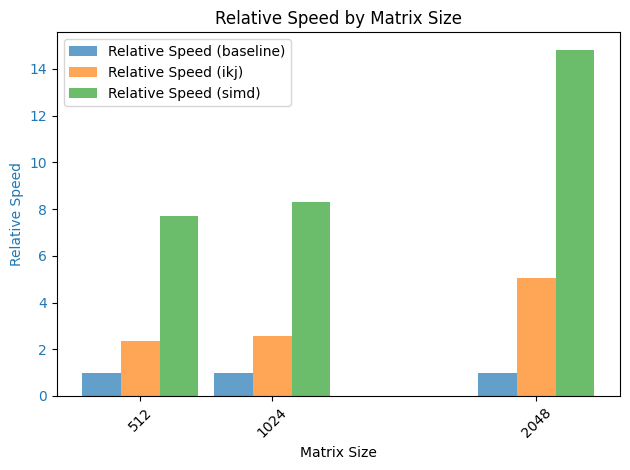

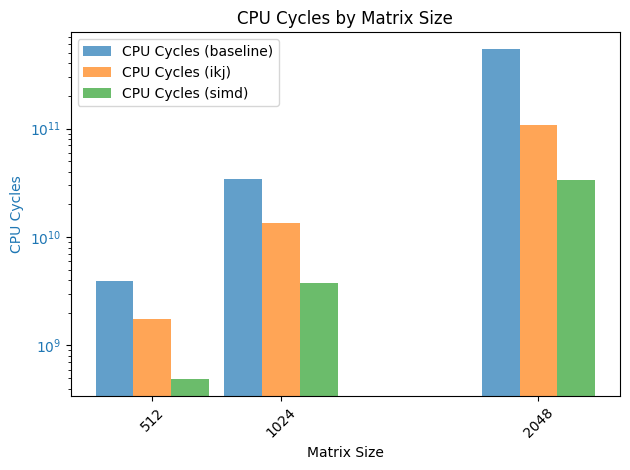

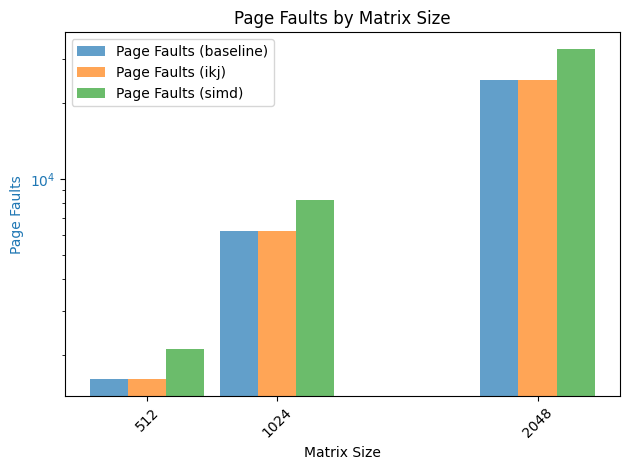

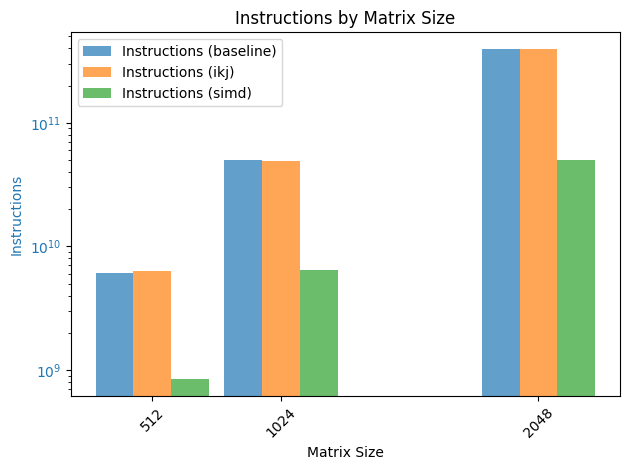

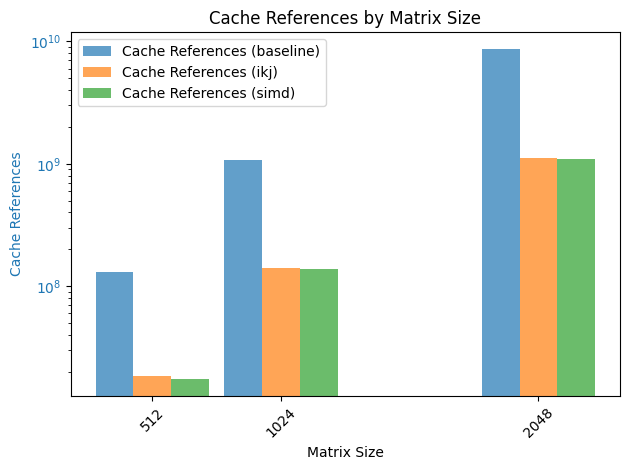

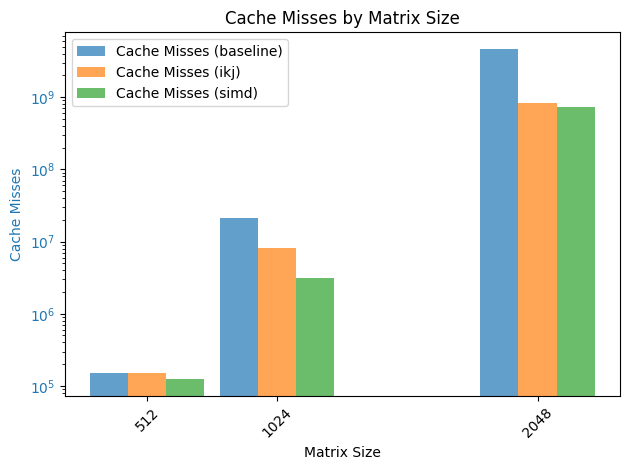

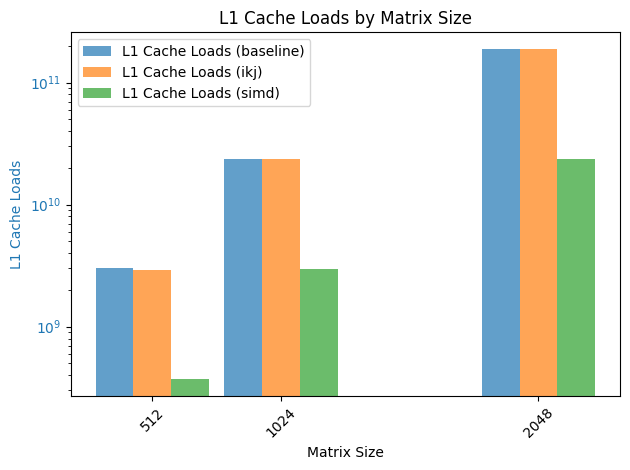

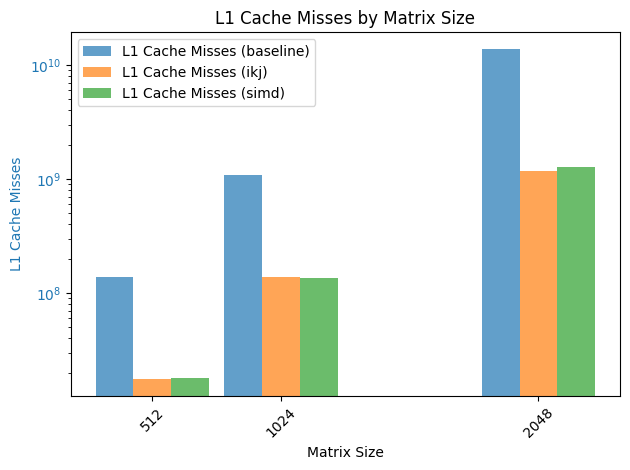

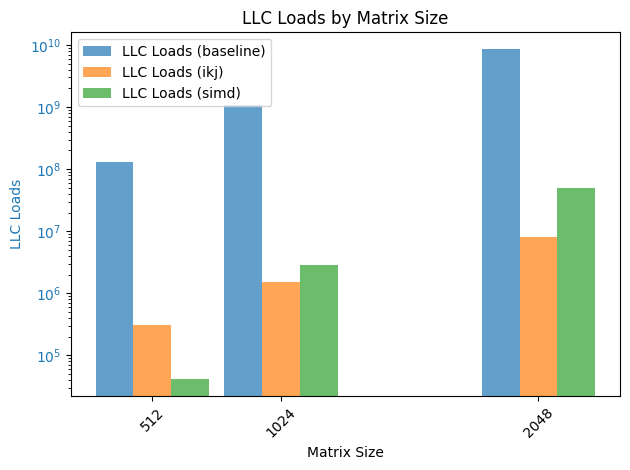

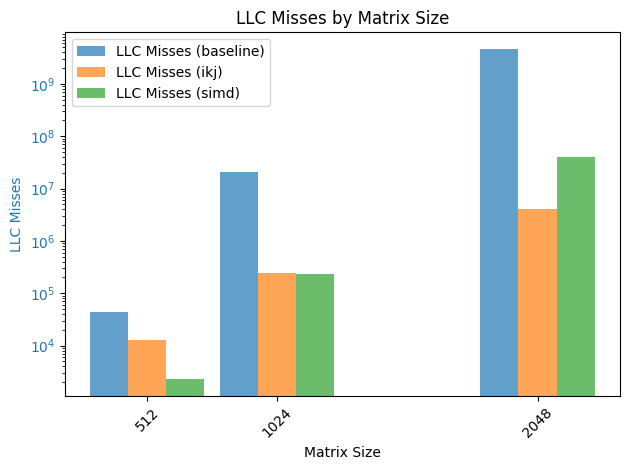

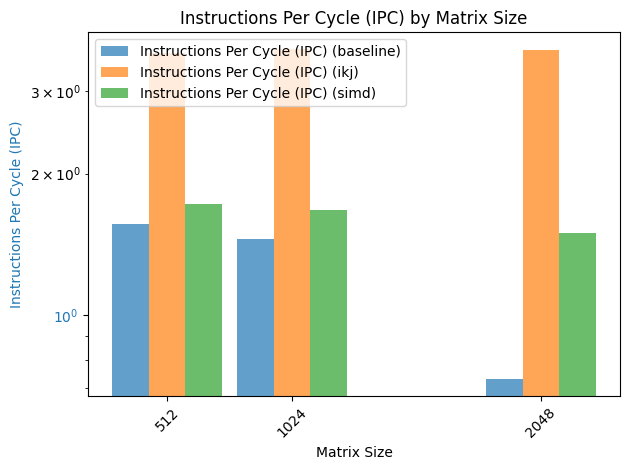

In [105]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 正则表达式匹配模式
pattern_method_size = re.compile(r"Running (\w+) with size (\d+)...")
pattern_execution_time = re.compile(r"Execution Time:\s+(\d+\.\d+) s")
pattern_cycles = re.compile(r"([\d,]+)\s+cycles")
pattern_page_faults = re.compile(r"([\d,]+)\s+page-faults")
pattern_instructions = re.compile(r"([\d,]+)\s+instructions")
pattern_cache_references = re.compile(r"([\d,]+)\s+cache-references")
pattern_cache_misses = re.compile(r"([\d,]+)\s+cache-misses")
pattern_l1_cache_loads = re.compile(r"([\d,]+)\s+L1-dcache-loads")
pattern_l1_cache_misses = re.compile(r"([\d,]+)\s+L1-dcache-load-misses")
pattern_llc_loads = re.compile(r"([\d,]+)\s+LLC-loads")
pattern_llc_misses = re.compile(r"([\d,]+)\s+LLC-load-misses")

# 用于存储解析的数据
data = {
    "Method": [],
    "Size": [],
    "Execution Time": [],
    "Cycles": [],
    "Page Faults": [],
    "Instructions": [],
    "Cache References": [],
    "Cache Misses": [],
    "L1 Cache Loads": [],
    "L1 Cache Misses": [],
    "LLC Loads": [],
    "LLC Misses": []
}

# 读取并解析文件内容
with open("simd.txt", "r") as file:
    current_method = ""
    current_size = 0
    for line in file:
        if match := pattern_method_size.search(line):
            current_method, current_size = match.groups()
            data["Method"].append(current_method)
            data["Size"].append(int(current_size))
        elif match := pattern_execution_time.search(line):
            data["Execution Time"].append(float(match.group(1)))
        elif match := pattern_cycles.search(line):
            data["Cycles"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_page_faults.search(line):
            data["Page Faults"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_instructions.search(line):
            data["Instructions"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_cache_references.search(line):
            data["Cache References"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_cache_misses.search(line):
            data["Cache Misses"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_l1_cache_loads.search(line):
            data["L1 Cache Loads"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_l1_cache_misses.search(line):
            data["L1 Cache Misses"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_llc_loads.search(line):
            data["LLC Loads"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_llc_misses.search(line):
            data["LLC Misses"].append(int(match.group(1).replace(",", "")))

# 转换为DataFrame
df = pd.DataFrame(data)
df["Relative Speed"] = df.groupby("Size")["Execution Time"].transform(lambda x: max(x) / x)

# 获取唯一的矩阵大小
sizes = df["Size"].unique()
sizes.sort()

# 设置柱状图的宽度
width = 150
colors = ['tab:blue', 'tab:orange', 'tab:green']

df["IPC"] = df["Instructions"] / df["Cycles"]

# 更新 performance_metrics 字典，包含 IPC
performance_metrics = {
    "Relative Speed": "Relative Speed",
    "Cycles": "CPU Cycles",
    "Page Faults": "Page Faults",
    "Instructions": "Instructions",
    "Cache References": "Cache References",
    "Cache Misses": "Cache Misses",
    "L1 Cache Loads": "L1 Cache Loads",
    "L1 Cache Misses": "L1 Cache Misses",
    "LLC Loads": "LLC Loads",
    "LLC Misses": "LLC Misses",
    "IPC": "Instructions Per Cycle (IPC)"
}

for metric, ylabel in performance_metrics.items():
    fig, ax = plt.subplots()

    ax.set_xlabel('Matrix Size')
    ax.set_ylabel(ylabel, color='tab:blue')
    
    # 如果不是相对速度，则使用对数刻度
    if metric != "Relative Speed":
        ax.set_yscale('log')  # 对其他指标设置对数刻度，以便更好展示不同数量级的差异

    for idx, (method, color) in enumerate(zip(df['Method'].unique(), colors)):
        method_data = df[df['Method'] == method]
        ax.bar(method_data['Size'] + (idx - 1) * width, method_data[metric], width=width, alpha=0.7, label=f'{ylabel} ({method})', color=color)

    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xticks(sizes)
    ax.set_xticklabels(sizes, rotation=45)

    # 设置标题和图例
    plt.title(f'{ylabel} by Matrix Size')
    fig.tight_layout()
    plt.legend(loc='upper left')

    plt.show()

In [107]:
import re
import pandas as pd

# 正则表达式匹配模式
pattern_method_size = re.compile(r"Running (\w+) with size (\d+)...")
pattern_execution_time = re.compile(r"Execution Time:\s+(\d+\.\d+) s")
pattern_instructions = re.compile(r"([\d,]+)\s+instructions")
pattern_cache_references = re.compile(r"([\d,]+)\s+cache-references")
pattern_cache_misses = re.compile(r"([\d,]+)\s+cache-misses")

# 用于存储解析的数据
data = {
    "Method": [],
    "Size": [],
    "Execution Time": [],
    "Instructions": [],
    "Cache References": [],
    "Cache Misses": []
}

# 读取并解析文件内容
with open("simd.txt", "r") as file:
    current_method = ""
    current_size = 0
    for line in file:
        if match := pattern_method_size.search(line):
            current_method, current_size = match.groups()
            data["Method"].append(current_method)
            data["Size"].append(int(current_size))
        elif match := pattern_execution_time.search(line):
            data["Execution Time"].append(float(match.group(1)))
        elif match := pattern_instructions.search(line):
            data["Instructions"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_cache_references.search(line):
            data["Cache References"].append(int(match.group(1).replace(",", "")))
        elif match := pattern_cache_misses.search(line):
            data["Cache Misses"].append(int(match.group(1).replace(",", "")))

# 转换为 DataFrame
df = pd.DataFrame(data)

# 计算 Cache Miss Rate (Cache Misses / Cache References)
df["Cache Miss Rate"] = df["Cache Misses"] / df["Cache References"]

# 只保留所需的列
df = df[["Method", "Size", "Execution Time", "Instructions", "Cache Misses", "Cache Miss Rate"]]

# 保存到 CSV 文件
csv_file_path = "simd_performance_metrics_filtered.csv"
df.to_csv(csv_file_path, index=False)

print(f"CSV file has been saved to {csv_file_path}")


CSV file has been saved to simd_performance_metrics_filtered.csv
